In [1]:
import os
import csv
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def unroll(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        l += (series[key])
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 3.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 2.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 1.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 0.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

In [3]:
# loading data

X_train_list = []
y_train_list = []

X_test_list = []
y_test_list = []

with open("..\\test_examples.txt") as t:
    test_examples = t.readlines()

for example in test_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = unroll(series)
    y_example = [float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9]
    X_test_list.append(x_example)
    y_test_list.append(y_example)

X_test = torch.tensor(X_test_list)
y_test = torch.tensor(y_test_list)
print(X_test.size())
print(y_test.size())

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

for example in training_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = unroll(series)
    y_example = [float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9]
    X_train_list.append(x_example)
    y_train_list.append(y_example)

X_train = torch.tensor(X_train_list)
y_train = torch.tensor(y_train_list)
print(X_train.size())
print(y_train.size())

torch.Size([93, 224])
torch.Size([93, 5])
torch.Size([371, 224])
torch.Size([371, 5])


In [18]:
# setting up FCNN

input_size = 224
hidden_layer_size_1 = 450
hidden_layer_size_2 = 400
hidden_layer_size_3 = 330
hidden_layer_size_4 = 250
hidden_layer_size_5 = 150
hidden_layer_size_6 = 50
output_size = 5
batch_size = 371
learning_rate = 0.001

adam_model = nn.Sequential(nn.Linear(input_size, hidden_layer_size_1),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_1, hidden_layer_size_2),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_2, hidden_layer_size_3),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_3, hidden_layer_size_4),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_4, hidden_layer_size_5),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_5, hidden_layer_size_6),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_6, output_size),
                        nn.Sigmoid())

'''
adam_model = nn.Sequential(nn.Linear(input_size, hidden_layer_size_1),
                        nn.SiLU(),
                        nn.Linear(hidden_layer_size_1, hidden_layer_size_2),
                        nn.SiLU(),
                        nn.Linear(hidden_layer_size_2, hidden_layer_size_3),
                        nn.SiLU(),
                        nn.Linear(hidden_layer_size_3, hidden_layer_size_4),
                        nn.SiLU(),
                        nn.Linear(hidden_layer_size_4, hidden_layer_size_5),
                        nn.SiLU(),
                        nn.Linear(hidden_layer_size_5, hidden_layer_size_6),
                        nn.SiLU(),
                        nn.Linear(hidden_layer_size_6, output_size),
                        nn.Sigmoid())

adam_model = nn.Sequential(nn.Linear(input_size, hidden_layer_size_1),
                        nn.Mish(),
                        nn.Linear(hidden_layer_size_1, hidden_layer_size_2),
                        nn.Mish(),
                        nn.Linear(hidden_layer_size_2, hidden_layer_size_3),
                        nn.Mish(),
                        nn.Linear(hidden_layer_size_3, hidden_layer_size_4),
                        nn.Mish(),
                        nn.Linear(hidden_layer_size_4, hidden_layer_size_5),
                        nn.Mish(),
                        nn.Linear(hidden_layer_size_5, hidden_layer_size_6),
                        nn.Mish(),
                        nn.Linear(hidden_layer_size_6, output_size),
                        nn.Sigmoid())
'''
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(adam_model.parameters(), lr=learning_rate)

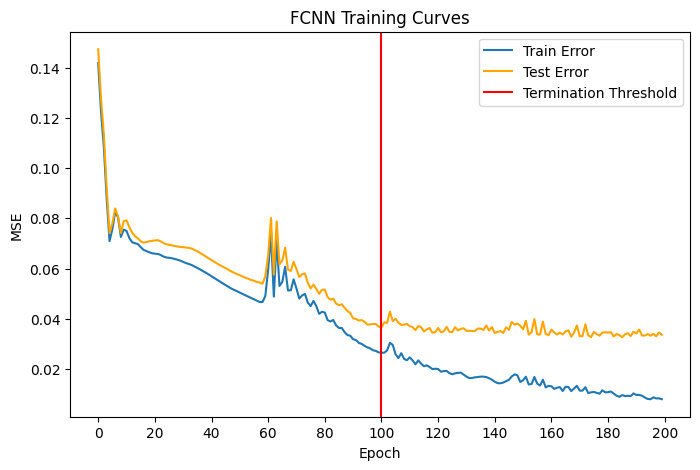

In [35]:
# model training

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

min_loss = 1.0
num_epochs = 200
#while (min_loss > 0.15):

adam_model.apply(init_weights)

losses = []
test_losses = []
for epoch in range(num_epochs):
    pred_y = adam_model(X_train)
    loss = loss_function(pred_y, y_train)
    losses.append(loss.item())

    test_y = adam_model(X_test)
    test_loss = loss_function(test_y, y_test)
    test_losses.append(test_loss.item())

    adam_model.zero_grad()
    loss.backward()

    optimizer.step()

min_loss = min(test_losses)

fig, ax = plt.subplots(1, figsize=(8, 5))

ax.plot(losses, label="Train Error")
ax.plot(test_losses, label="Test Error", c="orange")
ax.set_title("FCNN Training Curves")
ax.set_xticks(np.linspace(0, num_epochs, num=11))

ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")

ax.axvline(100, c='r', label='Training Termination')
ax.legend()

In [26]:
o_pred = []
f_pred = []
b_pred = []
s_pred = []
l_pred = []

o_truth = []
f_truth = []
b_truth = []
s_truth = []
l_truth = []

y_pred = adam_model(X_test)
for i in range(len(y_test)):
    o_truth.append(y_test[i][0] * 9)
    f_truth.append(y_test[i][1] * 9)
    b_truth.append(y_test[i][2] * 9)
    s_truth.append(y_test[i][3] * 9)
    l_truth.append(y_test[i][4] * 9)

    o_pred.append(y_pred[i][0] * 9)
    f_pred.append(y_pred[i][1] * 9)
    b_pred.append(y_pred[i][2] * 9)
    s_pred.append(y_pred[i][3] * 9)
    l_pred.append(y_pred[i][4] * 9)

print(E0(o_pred, o_truth))
print(E1(o_pred, o_truth))
print(E2(o_pred, o_truth))
print(E3(o_pred, o_truth))
print("\n\n")

print(E0(f_pred, f_truth))
print(E1(f_pred, f_truth))
print(E2(f_pred, f_truth))
print(E3(f_pred, f_truth))
print("\n\n")

print(E0(b_pred, b_truth))
print(E1(b_pred, b_truth))
print(E2(b_pred, b_truth))
print(E3(b_pred, b_truth))
print("\n\n")

print(E0(s_pred, s_truth))
print(E1(s_pred, s_truth))
print(E2(s_pred, s_truth))
print(E3(s_pred, s_truth))
print("\n\n")

print(E0(l_pred, l_truth))
print(E1(l_pred, l_truth))
print(E2(l_pred, l_truth))
print(E3(l_pred, l_truth))

0.0
41.935483870967744
69.89247311827957
84.94623655913979



0.0
68.81720430107526
87.09677419354838
95.6989247311828



0.0
56.98924731182796
75.26881720430107
83.87096774193549



0.0
56.98924731182796
84.94623655913979
94.6236559139785



0.0
74.19354838709677
87.09677419354838
92.47311827956989
